## 04 - part 3 - Filtering in the frequency domain

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import morphology

In [25]:
def print_image(image):
    plt.figure(figsize=(8,8))
    if len(image.shape) == 2:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.axis('off') # remove axis with numbers

In [3]:
def to_gray_scale(image: np.ndarray) -> np.ndarray:
    if len(image.shape) <= 2:
        return image #Se for RGB converte para Gray, senão apenas mantém
    return np.dot(image, [0.2989, 0.5870, 0.1140]).astype(np.int64)

In [4]:
def filter_gaussian(P, Q):
    s1 = P
    s2 = Q

    D = np.zeros([P, Q])  # Compute Distances
    for u in range(P):
        for v in range(Q):
            x = (u-(P/2))**2/(2*s1**2) + (v-(Q/2))**2/(2*s2**2)
            D[u, v] = np.exp(-x)
    return D

In [5]:
def map_value_to_color(value, min_val, max_val, colormap):
    # Scale the value to the range [0, len(colormap) - 1]
    scaled_value = (value - min_val) / (max_val - min_val) * (len(colormap) - 1)
    # Determine the two closest colors in the colormap
    idx1 = int(scaled_value)
    idx2 = min(idx1 + 1, len(colormap) - 1)
    # Interpolate between the two colors based on the fractional part
    frac = scaled_value - idx1
    color = [
        (1 - frac) * colormap[idx1][0] + frac * colormap[idx2][0],
        (1 - frac) * colormap[idx1][1] + frac * colormap[idx2][1],
        (1 - frac) * colormap[idx1][2] + frac * colormap[idx2][2]
    ]
    return color

In [6]:
def create_heatmap(N, M):
    heatmap_colors = [
        [1, 0, 1],   # Pink
        [0, 0, 1],   # Blue
        [0, 1, 0],   # Green
        [1, 1, 0],   # Yellow
        [1, 0, 0]    # Red
    ]
    
    color_distribution = filter_gaussian(M, N)
    min_val = np.min(np.array(color_distribution))
    max_val = np.max(np.array(color_distribution))
    heatmap_image = np.zeros([M, N, 3]) #Imagem RGB vazia
    for i in range(M):
        for j in range(N):
            heatmap_image[i, j] = map_value_to_color(color_distribution[i, j], min_val, max_val, heatmap_colors)
    return heatmap_image

In [93]:
# def erosion(image, structure):
#     # Get the dimensions of the image and the structure
#     rows, cols = image.shape
#     k_rows, k_cols = structure.shape
    
#     # Get the center pixel of the structure
#     center_row, center_col = k_rows // 2, k_cols // 2
    
#     # Initialize the result matrix with ones
#     result = np.ones_like(image)
    
#     # Iterate through each pixel in the image
#     for i in range(rows):
#         for j in range(cols):
#             # Check if the structure fits completely at the current position
#             if (i - center_row >= 0) and (i + k_rows - center_row <= rows) and \
#                (j - center_col >= 0) and (j + k_cols - center_col <= cols):
#                 # Extract the sub-matrix of the image centered at (i, j)
#                 sub_matrix = image[i - center_row:i + k_rows - center_row,
#                                    j - center_col:j + k_cols - center_col]
#                 # Perform element-wise AND operation between the sub-matrix and the structure
#                 result[i, j] = np.min(sub_matrix * structure)
#             else:
#                 # If the structure doesn't fit completely, set the result to 0
#                 result[i, j] = 0
                
#     return result.astype(np.uint8)

def erosion(image):
    structure = morphology.square(3)
    return morphology.binary_erosion(image, structure) * 255

In [94]:
def dilation(image):
    structure = morphology.square(3)
    return morphology.binary_dilation(image, structure) * 255

In [9]:
def thresholding(f, L):
    # create a new image with zeros
    f_tr = np.ones(f.shape).astype(np.uint8)
    # setting to 0 the pixels below the threshold
    f_tr[np.where(f < L)] = 0
    return f_tr    

In [10]:
# def otsu_threshold(img):
    
#     M = np.product(img.shape)
#     min_var = []
#     hist_t,_ = np.histogram(img, bins=256, range=(0,256))
    
#     img_t = thresholding(img, 0)
    
#     for L in np.arange(1, 255):
#         img_ti = thresholding(img, L)
#         # computing weights
#         w_a = np.sum(hist_t[:L])/float(M)
#         w_b = np.sum(hist_t[L:])/float(M)
#         # computing variances
#         sig_a = np.var(img[np.where(img_ti == 0)])
#         sig_b = np.var(img[np.where(img_ti == 1)])
#         print(sig_a)
        
#         min_var = min_var + [w_a*sig_a + w_b*sig_b]
        
#     img_t = thresholding(img, np.argmin(min_var))
#     print(min_var)
    
#     return img_t

In [11]:
def otsu_thresholding(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = np.mean(image, axis=2, dtype=np.uint8)
    else:
        gray = np.copy(image)

    # Calculate histogram
    hist, _ = np.histogram(gray, bins=np.arange(256))
    
    # Normalize histogram
    hist_norm = hist.astype(np.float32) / np.sum(hist)

    # Initialization
    threshold = 0
    max_var = 0

    # Compute inter-class variance for all possible thresholds
    for t in range(1, 255):
        # Background probabilities and means
        w0 = np.sum(hist_norm[:t])
        w1 = 1 - w0
        if w0 == 0 or w1 == 0:
            continue
        u0 = np.sum(np.arange(t) * hist_norm[:t]) / w0
        u1 = np.sum(np.arange(t, 255) * hist_norm[t:]) / w1

        # Compute inter-class variance
        var = w0 * w1 * (u0 - u1) ** 2

        # Update threshold if variance is larger
        if var > max_var:
            max_var = var
            threshold = t

    # Apply thresholding
    thresholded = (gray > threshold) * 255

    return thresholded.astype(np.uint8)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_23588\1386628817.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgbin = to_gray_scale(imageio.imread("images/morpho.png"))


TypeError: erosion() takes 1 positional argument but 2 were given

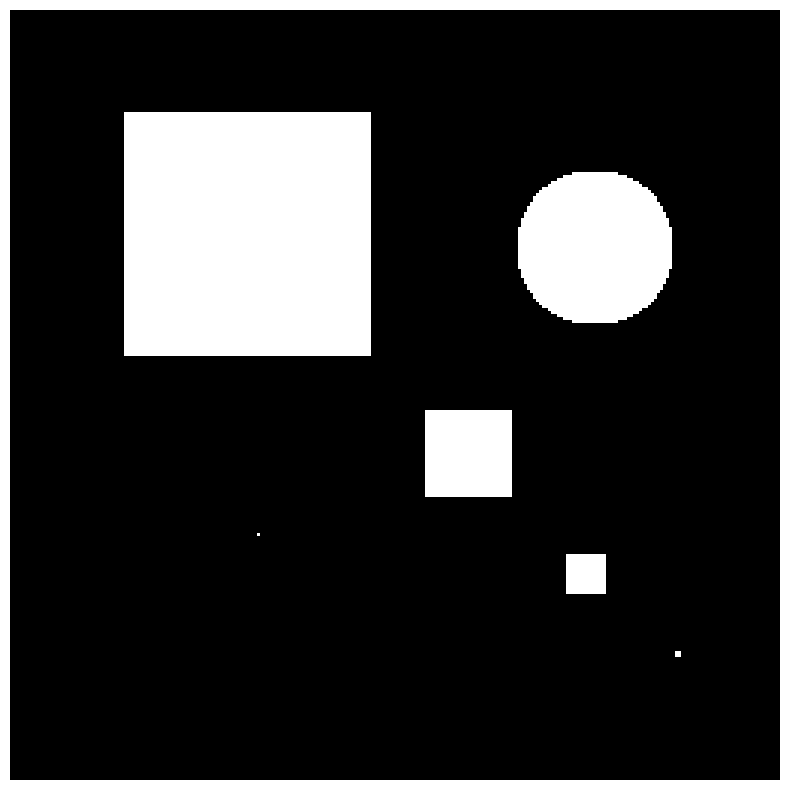

In [12]:
imgbin = to_gray_scale(imageio.imread("images/morpho.png"))
# disk = np.array([[0, 0, 0, 1, 0, 0, 0],
#        [0, 1, 1, 1, 1, 1, 0],
#        [0, 1, 1, 1, 1, 1, 0],
#        [1, 1, 1, 1, 1, 1, 1],
#        [0, 1, 1, 1, 1, 1, 0],
#        [0, 1, 1, 1, 1, 1, 0],
#        [0, 0, 0, 1, 0, 0, 0]])

disk = np.array([[0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]])

disk = morphology.disk(7)

# disk = np.array([[1]])
# print(imgbin.shape)
# print_image(imgbin)
print_image(morphology.binary_erosion(imgbin, disk))
print_image(erosion(imgbin, disk))

In [13]:
def read_image(image_name):
    return imageio.imread(f"images/{image_name}")

In [14]:
def rms_error(img, out):
    M,N = img.shape
    error = ((1/(M*N))*np.sum((img-out)**2))**(1/2)
    return error

In [113]:
def color_rms_error(img, out):
    return np.round(np.average([rms_error(img[:,:,0], out[:,:,0]), rms_error(img[:,:,1], out[:,:,1]), rms_error(img[:,:,2], out[:,:,1])]), 4)

In [17]:
def get_images():    
    # base_image_name = input().rstrip()
    # reference_image_name = input().rstrip()
    
    base_image = read_image(base_image_name)
    reference_image = read_image(reference_image_name)

    return base_image, reference_image

In [18]:
def get_indexes():
    # indexes_input = input().rstrip()
    return indexes_input.split(' ')

In [19]:
def apply_commands(image, indexes):
    for index in indexes:
        match index:
            case '1':
                image = erosion(image)
            case '2':
                image = dilation(image)
    return image

In [20]:
def to_rgb(image):
    h, w = image.shape
    rgb_image = np.empty((h, w, 3), dtype=np.uint8)
    rgb_image[:, :, 0] = image
    rgb_image[:, :, 1] = image
    rgb_image[:, :, 2] = image

    return rgb_image

In [62]:
def normalize(image):
    return (image - np.min(image)) * (255 / (np.max(image) - np.min(image)))

In [109]:
def apply_colored_mask(base_image, mask):
    heatmap = create_heatmap(base_image.shape[0], base_image.shape[1])
    result_image = np.zeros((base_image.shape[0], base_image.shape[1], 3))
    for i in range(base_image.shape[0]):
        for j in range(base_image.shape[1]):
            if mask[i][j] == 255:
                result_image[i][j][0] = 1
                result_image[i][j][1] = 1
                result_image[i][j][2] = 1
            else:
                result_image[i][j] = heatmap[i][j]
    return normalize(result_image).astype(np.uint8)

In [96]:
def combine_mask(base_image, colored_mask, alpha):
    return ((1 - alpha) * to_rgb(base_image) + alpha * colored_mask).astype(np.uint8)

In [16]:
base_image_name = "chest_xray_1.png"
reference_image_name = "chest_xray_1_ref-case1.png"
indexes_input = "2 2 2 2 2 2 2 2 2 1 1 1 "

C:\Users\Lucas\AppData\Local\Temp\ipykernel_23588\1778181336.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(f"images/{image_name}")


10.034811651881226


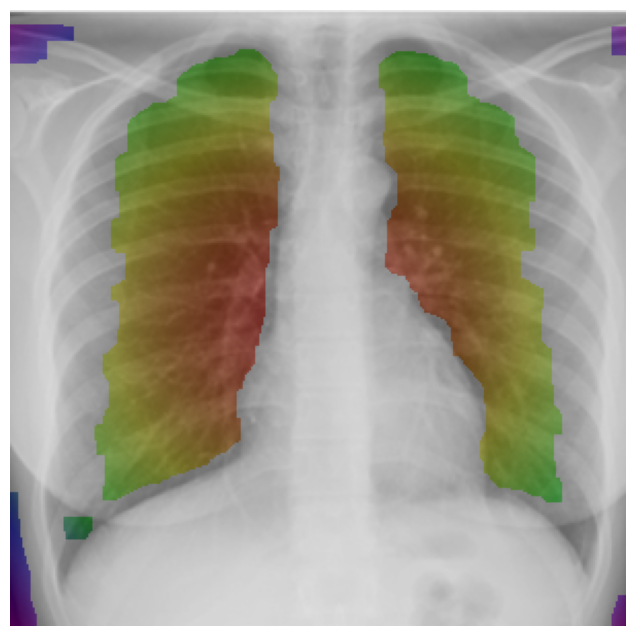

In [114]:
def main():
    base_image, reference_image = get_images()
    indexes = get_indexes()
    
    base_image = to_gray_scale(base_image)
    mask = otsu_thresholding(base_image)
    mask = apply_commands(mask, indexes)
    colored_mask = apply_colored_mask(base_image, mask)
    final_image = combine_mask(base_image, colored_mask, 0.3)
    
    print_image(final_image)
    print(color_rms_error(final_image, reference_image))
main()